## Import libraries

In [1]:
import torch
import os.path as op
import nibabel as nib
import numpy as np
from nilearn import plotting

import torch.nn as nn
from torch.utils.data import DataLoader

from datasets import SimulationDataset
from model import Autoencoder3D

/Users/greg/code/gkiar/3d-cnn-ae/env/cn/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Create helper functions

In [2]:
def groom(im):
    if isinstance(im, nib.Nifti1Image):
        sample = im
    else:
        sample = nib.load(im)
    sample = sample.get_data().copy().astype(float)
    sample = np.nan_to_num(sample)
    sample *= 1.0/np.abs(sample).max()
    sample = torch.tensor(sample).view((1), (1), *sample.shape)
    return sample.type('torch.FloatTensor')

In [3]:
def recreate_im(immat, affine, header):
    tmpdat = immat.detach().numpy().reshape(*immat.shape[2:])
    return nib.Nifti1Image(tmpdat, affine=affine, header=header) 

In [4]:
def my_mse(im1, im2):
    return np.mean(np.power(im1-im2, 2))

In [5]:
tensor2np = lambda x: x.detach().numpy().reshape(*x.shape[2:])

### Load model and images, show reconstruction

In [6]:
fl = '../data/training_5_conv/model_epoch_1.pt'
model = torch.load(fl, map_location="cpu")
if isinstance(model, dict):
    tmpmodel = Autoencoder3D()
    tmpmodel.load_state_dict(model['model_state_dict'])
    model = tmpmodel
    
model = model.eval()

In [7]:
tmpimg = '/Users/greg/code/gkiar/analytical-stability/code/realoutdir/10/executive_ri_z.nii.gz'

tmp = nib.load(tmpimg)
affine = tmp.affine.copy()
header = tmp.header

In [8]:
inn = groom(tmpimg)
out = model(inn)

inim = recreate_im(inn, affine, header)
outim = recreate_im(out, affine, header)

In [9]:
print("Orig:")
print(inn.min(), inn.max())
print(my_mse(tensor2np(inn), np.zeros_like(tensor2np(inn))))

print("\nReconst:")
print(out.min(), out.max())
print(my_mse(tensor2np(out), np.zeros_like(tensor2np(out))))

Orig:
tensor(-0.4896) tensor(1.)
0.008137611

Reconst:
tensor(-0.5553, grad_fn=<MinBackward1>) tensor(0.6444, grad_fn=<MaxBackward1>)
0.0023196803


In [10]:
distance = nn.MSELoss()

print(distance(inn, out))
print(my_mse(tensor2np(inn), tensor2np(out)))

tensor(0.0062, grad_fn=<MeanBackward0>)
0.0062011313


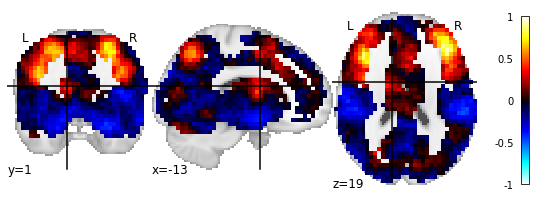

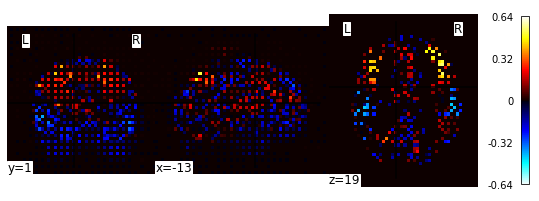

In [11]:
# plotting.plot_roi(inim,  cut_coords=[-13, 1, 19], threshold=0, vmin=-10, vmax=10)
# plotting.plot_roi(outim, cut_coords=[-13, 1, 19], threshold=0, vmin=-10, vmax=10)

plotting.plot_stat_map(inim,  cut_coords=[-13, 1, 19], threshold=0)
plotting.plot_stat_map(outim, cut_coords=[-13, 1, 19], threshold=0)

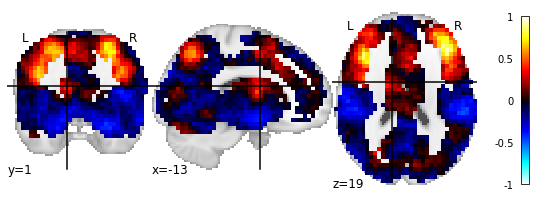

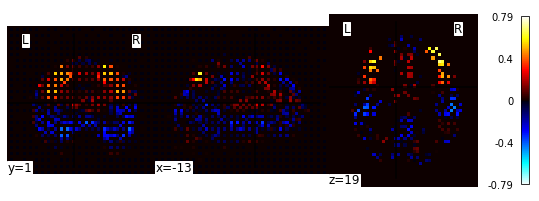

In [11]:
# plotting.plot_roi(inim,  cut_coords=[-13, 1, 19], threshold=0, vmin=-10, vmax=10)
# plotting.plot_roi(outim, cut_coords=[-13, 1, 19], threshold=0, vmin=-10, vmax=10)

plotting.plot_stat_map(inim,  cut_coords=[-13, 1, 19], threshold=0)
plotting.plot_stat_map(outim, cut_coords=[-13, 1, 19], threshold=0)

### View simulated data

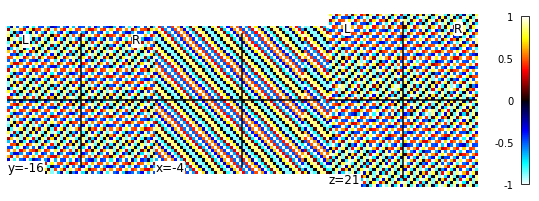

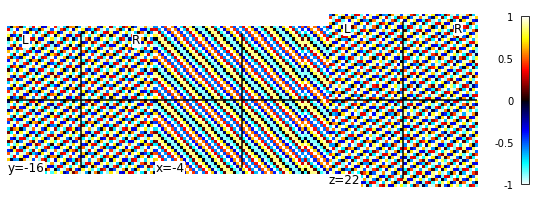

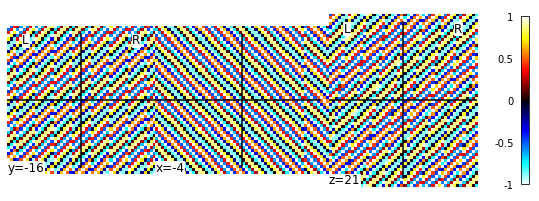

In [12]:
data_shape = (48, 56, 48)
n = 5
simdat = SimulationDataset(shape=data_shape, n_samples=3)
simdat_loader = DataLoader(simdat, batch_size=1)

simexamples = list(enumerate(simdat_loader))
for d in simexamples:
    simni = recreate_im(d[1], affine, header)
    plotting.plot_stat_map(simni)

In [13]:
# minfl = '../data/sim_simplified_data/model_final.pt'
# minfl = '../data/sim_tanh/model_final.pt'
minfl = '../data/sim_1_interp/model_epoch_5.pt'
simmodel = torch.load(minfl, map_location="cpu")
if isinstance(simmodel, dict):
    tmpmodel = Autoencoder3D()
    tmpmodel.load_state_dict(simmodel['model_state_dict'])
    simmodel = tmpmodel

simmodel = simmodel.eval()

In [14]:
s_inn = groom(simni)
s_out = simmodel(s_inn)

s_inim = recreate_im(s_inn, affine, header)
s_outim = recreate_im(s_out, affine, header)

/Users/greg/code/gkiar/3d-cnn-ae/env/cnn/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [15]:
print("Orig:")
print(s_inn.min(), s_inn.max())
print(my_mse(tensor2np(s_inn), np.zeros_like(tensor2np(s_inn))))

print("\nReconst:")
print(s_out.min(), s_out.max())
print(my_mse(tensor2np(s_out), np.zeros_like(tensor2np(s_out))))

Orig:
tensor(-1.) tensor(1.)
0.50000346

Reconst:
tensor(-0.9796, grad_fn=<MinBackward1>) tensor(0.9801, grad_fn=<MaxBackward1>)
0.15399507


In [16]:
distance = nn.MSELoss()

print(distance(s_inn, s_out))
print(my_mse(tensor2np(s_inn), tensor2np(s_out)))

tensor(0.3210, grad_fn=<MeanBackward0>)
0.32100406


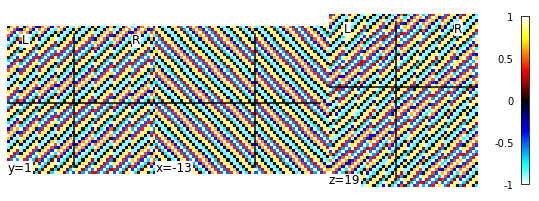

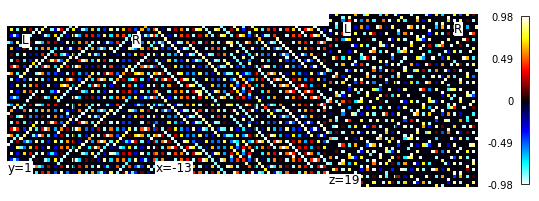

In [17]:
plotting.plot_stat_map(s_inim,  cut_coords=[-13, 1, 19], threshold=0)
plotting.plot_stat_map(s_outim, cut_coords=[-13, 1, 19], threshold=0)